# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [153]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [8]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("sparkify SQL") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = "mini_sparkify_event_data.json"
spark_df = spark.read.json(path)

In [4]:
spark_df.count()

286500

In [5]:
spark_df.createOrReplaceTempView("spark_df_table")

check if userID or sessionID is null

In [6]:
spark.sql('''
            SELECT *
            FROM spark_df_table
            WHERE userID is NULL OR sessionId is NULL
          '''
         ).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



check if userID and sessionID is empty

In [7]:
spark.sql('''
            SELECT *
            FROM spark_df_table
            WHERE userID = "" OR sessionId = ""
          '''
         ).show()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

In [8]:
spark_df_clean=spark_df.filter(spark_df["userId"]!="")

In [9]:
spark_df.count()

286500

In [10]:
spark_df_clean.count()

278154

In [11]:
spark_df_clean=spark_df_clean.dropna(how="any",subset=["userId",'sessionId'])

In [12]:
spark_df_clean.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Add churn 
create an addition columns named churn. If the value in this column is 1, then this user cancelled his/her service eventually.

In [13]:
spark_df_clean.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [14]:
get_cancel=udf(lambda x:1 if x=='Cancellation Confirmation' else 0)

In [15]:
spark_df_clean=spark_df_clean.withColumn("Churn",get_cancel(spark_df_clean['page']))

In [16]:
spark_df_clean.filter(spark_df_clean["Churn"]==1).show(1)

+------+---------+---------+------+-------------+--------+------+-----+------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|          location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|Churn|
+------+---------+---------+------+-------------+--------+------+-----+------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|    1|
+------+---------+---------+------+-------------+--------+------+-----+------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------

In [17]:
spark_df_clean.select('Churn').dropDuplicates().show()

+-----+
|Churn|
+-----+
|    0|
|    1|
+-----+



right now, only the rows with page value = cancel confirmation have churn value = 1, I need to assign 1 to churn columns for all rows that belongs to the user who canceled the service

In [18]:
churnlist=spark_df_clean.filter(spark_df_clean["Churn"]==1).select('userId').dropDuplicates().collect()
# add .collect() otherwise if will store it as a dataframe not a list

In [19]:
churn_list=[x['userId'] for x in churnlist]

In [20]:
assign_churn=udf(lambda x:1 if x in churn_list else 0)

In [21]:
spark_df_clean=spark_df_clean.withColumn("Churn",assign_churn(spark_df_clean['userId']))

In [22]:
spark_df_clean.filter(spark_df_clean["userId"]==18).select('Churn').show(2)

+-----+
|Churn|
+-----+
|    1|
|    1|
+-----+
only showing top 2 rows



#### Add downgrade columns

In [23]:
get_downgrade=udf(lambda x:1 if x=='Downgrade' else 0)

In [24]:
spark_df_clean=spark_df_clean.withColumn("Downgrade",get_cancel(spark_df_clean['page']))

In [25]:
spark_df_clean.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+---------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|Churn|Downgrade|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+---------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|        0|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+------

In [26]:
downgradelist=spark_df_clean.filter(spark_df_clean["Downgrade"]==1).select('userId').dropDuplicates().collect()
downgrade_list=[x['userId'] for x in downgradelist]
assign_downgrade=udf(lambda x:1 if x in downgrade_list else 0)
spark_df_clean=spark_df_clean.withColumn("Downgrade",assign_downgrade(spark_df_clean['userId']))

In [27]:
spark_df_clean.filter(spark_df_clean["Downgrade"]==1).select('userId').dropDuplicates().show(2)

+------+
|userId|
+------+
|   125|
|    51|
+------+
only showing top 2 rows



In [28]:
spark_df_clean.filter(spark_df_clean["userId"]==125).select('Downgrade').show(2)

+---------+
|Downgrade|
+---------+
|        1|
|        1|
+---------+
only showing top 2 rows



#### Convert ts to real time

In [29]:
gen_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
spark_df_clean = spark_df_clean.withColumn("time", gen_time(spark_df_clean['ts']))

In [30]:
spark_df_clean.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+---------+-------------------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|Churn|Downgrade|               time|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+---------+-------------------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|        0|2018-09-30 20:01:57|
+--------------+---------+---------+------+-------------+-------

In [31]:
gen_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
spark_df_clean = spark_df_clean.withColumn("hour", gen_hour(spark_df_clean['ts']))

gen_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
spark_df_clean = spark_df_clean.withColumn("weekday", gen_weekday(spark_df_clean['ts']))

gen_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
spark_df_clean = spark_df_clean.withColumn("day", gen_day(spark_df_clean['ts']))

#### Convert location to state

In [32]:
get_state=udf(lambda x:x[-2:])
spark_df_clean = spark_df_clean.withColumn("location_state", get_state(spark_df_clean['location']))

In [33]:
spark_df_clean.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+---------+-------------------+----+-------+---+--------------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|Churn|Downgrade|               time|hour|weekday|day|location_state|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+---------+-------------------+----+-------+---+--------------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0

#### simplify userAgent
This will show the system that user used for sparkify

In [34]:
spark_df_clean.select('userAgent').dropDuplicates().collect()

[Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW6

In [35]:
simp_useragent=udf(lambda x:"".join(x[x.index('(')+1:x.index(')')]))

In [36]:
spark_df_clean= spark_df_clean.withColumn("sim_user_agent", simp_useragent(spark_df_clean['userAgent']))

In [37]:
spark_df_clean.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+---------+-------------------+----+-------+---+--------------+--------------------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|Churn|Downgrade|               time|hour|weekday|day|location_state|      sim_user_agent|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-----+---------+-------------------+----+-------+---+--------------+--------------------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|R

There are several features that I am interested to explore: gender,location(state),level,method,userAgent(simplified)

In [38]:
spark_df_clean.select('gender').dropDuplicates().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [39]:
spark_df_clean.select('level').dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [40]:
spark_df_clean.select('method').dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [41]:
spark_df_clean.select('location_state').dropDuplicates().show()

+--------------+
|location_state|
+--------------+
|            AZ|
|            SC|
|            LA|
|            NJ|
|            OR|
|            VA|
|            KY|
|            NH|
|            MI|
|            NV|
|            WI|
|            ID|
|            CA|
|            CT|
|            MT|
|            NC|
|            MD|
|            MO|
|            IL|
|            WA|
+--------------+
only showing top 20 rows



In [42]:
spark_df_clean.select('sim_user_agent').dropDuplicates().collect()

[Row(sim_user_agent='iPad; CPU OS 7_1_2 like Mac OS X'),
 Row(sim_user_agent='Macintosh; Intel Mac OS X 10_8_5'),
 Row(sim_user_agent='Macintosh; Intel Mac OS X 10.9; rv:31.0'),
 Row(sim_user_agent='iPad; CPU OS 7_1_1 like Mac OS X'),
 Row(sim_user_agent='Windows NT 6.2; WOW64; rv:31.0'),
 Row(sim_user_agent='Windows NT 6.1; WOW64'),
 Row(sim_user_agent='Macintosh; Intel Mac OS X 10_9_4'),
 Row(sim_user_agent='Windows NT 6.1; rv:31.0'),
 Row(sim_user_agent='X11; Ubuntu; Linux i686; rv:31.0'),
 Row(sim_user_agent='Windows NT 5.1'),
 Row(sim_user_agent='Macintosh; Intel Mac OS X 10_9_3'),
 Row(sim_user_agent='compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0'),
 Row(sim_user_agent='X11; Linux x86_64'),
 Row(sim_user_agent='iPhone; CPU iPhone OS 7_1_2 like Mac OS X'),
 Row(sim_user_agent='Windows NT 6.2; WOW64'),
 Row(sim_user_agent='Windows NT 6.1; WOW64; rv:30.0'),
 Row(sim_user_agent='Macintosh; Intel Mac OS X 10.7; rv:31.0'),
 Row(sim_user_agent='Windows NT 6.3; WOW64; rv:31.0'),
 Row

### Cancellation service - data exploration

#### Gender distribution between churn user and normal user

In [43]:
df_gender=spark_df_clean.dropDuplicates(["userId"]).groupby(["Churn", "gender"]).count().sort("Churn").toPandas()

In [44]:
df_gender

Churn gender  count
0     0      M     89
1     0      F     84
2     1      M     32
3     1      F     20

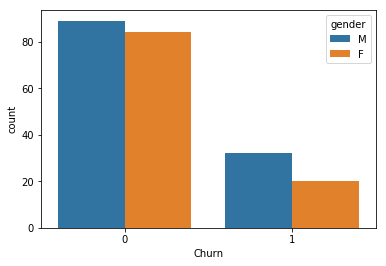

In [45]:
sns.barplot(x='Churn', y='count', hue='gender', data=df_gender)

#### level distribution between churn user and normal user

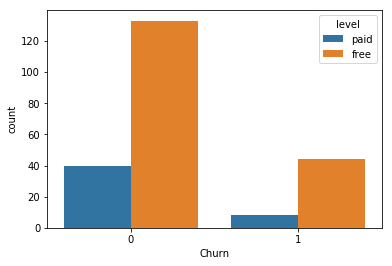

In [46]:
df_level=spark_df_clean.dropDuplicates(["userId"]).groupby(["Churn", "level"]).count().sort("Churn").toPandas()
sns.barplot(x='Churn', y='count', hue='level', data=df_level)

#### method distribution between churn user and normal user

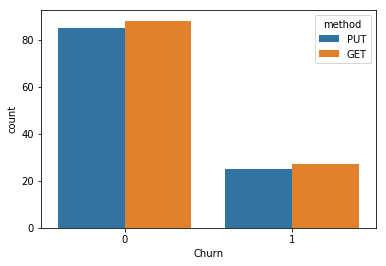

In [47]:
df_method=spark_df_clean.dropDuplicates(["userId"]).groupby(["Churn", "method"]).count().sort("Churn").toPandas()
sns.barplot(x='Churn', y='count', hue='method', data=df_method)

#### location(state) distribution between churn and normal user

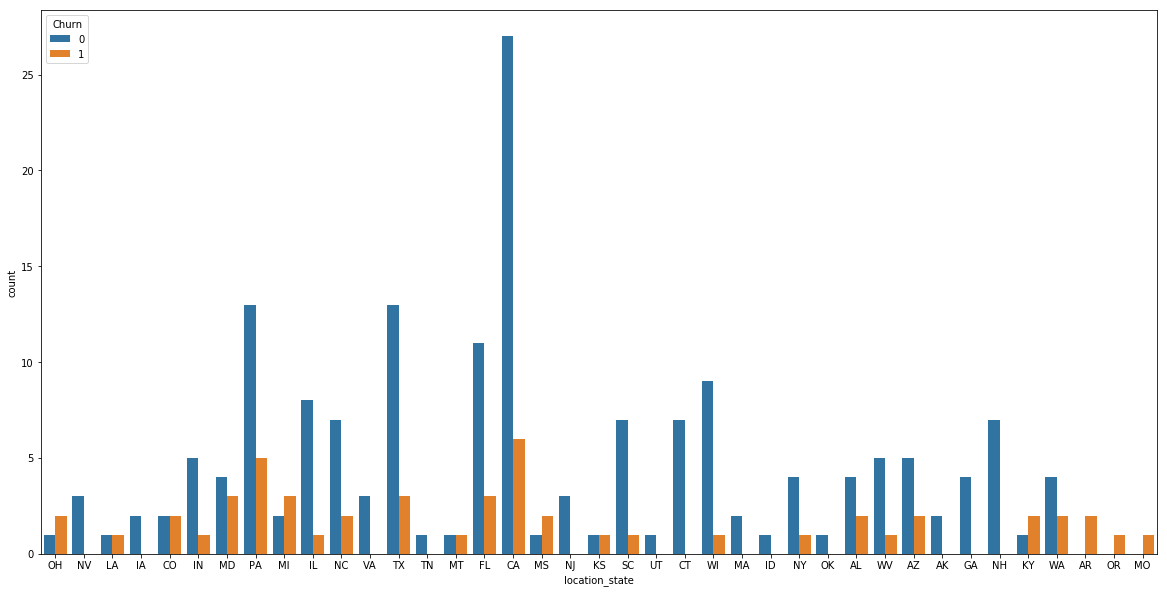

In [48]:
plt.figure(figsize=(20,10))
df_state=spark_df_clean.dropDuplicates(["userId"]).groupby(["Churn", "location_state"]).count().sort("Churn").toPandas()
sns.barplot(x='location_state', y='count', hue='Churn', data=df_state)


#### page distribution between churn user and normal user

In [49]:
df_page=spark_df_clean.groupby(["Churn", "page"]).count().sort("Churn").toPandas()

In [50]:
df_page=df_page[(df_page['page']!="NextSong")&(df_page['page']!="Cancellation Confirmation")&(df_page['page']!="Cancel")]

In [51]:
df_page['page'].unique()

array(['Submit Upgrade', 'Upgrade', 'Error', 'Add Friend', 'Thumbs Up',
       'Save Settings', 'Logout', 'Submit Downgrade', 'Add to Playlist',
       'Help', 'Downgrade', 'Thumbs Down', 'Home', 'About', 'Settings',
       'Roll Advert'], dtype=object)

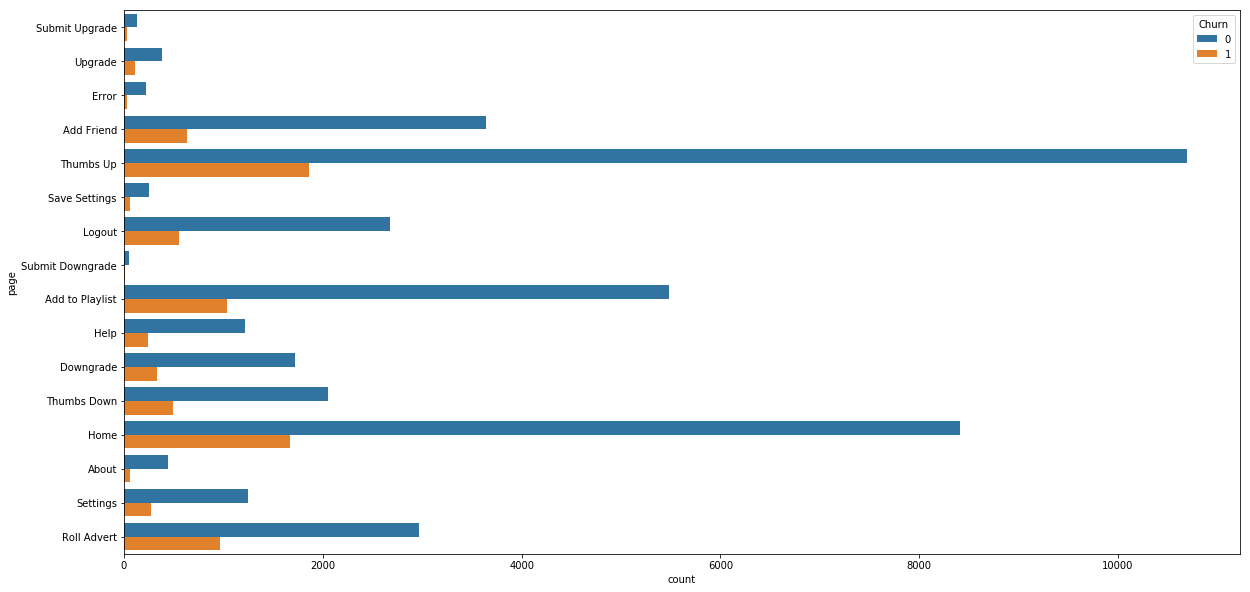

In [52]:
plt.figure(figsize=(20,10))
sns.barplot(x='count', y='page', hue='Churn', data=df_page)

session statistic for churn user and normal user

In [53]:
df_sessionid=spark_df_clean.groupby("sessionId", "Churn").count().sort("sessionId",'count').toPandas()

In [54]:
df_sessionid.head()

sessionId Churn  count
0          1     1    252
1          1     0    428
2          2     0      7
3          3     1      2
4          3     0     35

In [55]:
df_sessionid_churn=df_sessionid[df_sessionid['Churn']=='1']

In [56]:
temp_col=list(df_sessionid_churn.columns)
temp_col[2]='count_churn'
df_sessionid_churn.columns=temp_col

In [57]:
df_sessionid_churn.head(1)

sessionId Churn  count_churn
0          1     1          252

In [58]:
df_sessionid_normal=df_sessionid[df_sessionid['Churn']=='0']
temp_col=list(df_sessionid_normal)
temp_col[2]='count_normal'
df_sessionid_normal.columns=temp_col

In [59]:
df_sessionid_normal.head(1)

sessionId Churn  count_normal
1          1     0           428

In [60]:
df_sessionid_count=pd.merge(df_sessionid_normal, df_sessionid_churn, on='sessionId',how="outer").fillna(0)

In [61]:
df_sessionid_count=df_sessionid_count[['sessionId','count_normal','count_churn']]

In [62]:
df_sessionid_count['churn_per']=df_sessionid_count['count_churn']/(df_sessionid_count['count_normal']+df_sessionid_count['count_churn'])

In [63]:
df_sessionid_count.sort_values('churn_per',ascending=False).head(2)

sessionId  count_normal  count_churn  churn_per
2311       2003           0.0        109.0        1.0
2237       1111           0.0          1.0        1.0

df_seesionid_count show that the percentage of churn users in each session

Time(hours in a day, days in a week, days in a month) distribution for churn user and normal user

In [64]:
df_hour=spark_df_clean.filter(spark_df_clean['page']=='NextSong').groupby(["Churn", "hour"]).count().sort("Churn").toPandas()

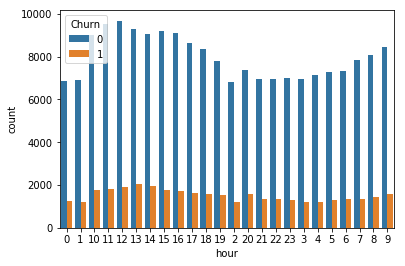

In [65]:
sns.barplot(x='hour', y='count', hue='Churn', data=df_hour)

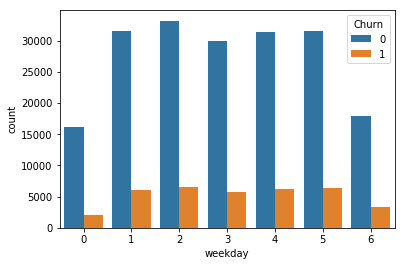

In [66]:
df_weekday=spark_df_clean.filter(spark_df_clean['page']=='NextSong').groupby(["Churn", "weekday"]).count().sort("Churn").toPandas()
sns.barplot(x='weekday', y='count', hue='Churn', data=df_weekday)

In [67]:
df_day=spark_df_clean.filter(spark_df_clean['page']=='NextSong').groupby(["Churn", "day"]).count().sort("day").toPandas()

In [68]:
df_day['day']=pd.to_numeric(df_day['day'])

In [69]:
df_day=df_day.sort_values('day')

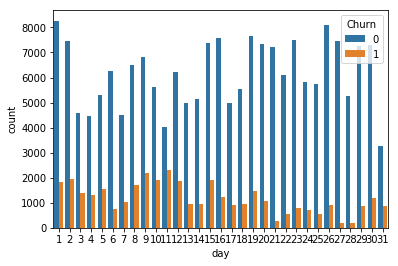

In [70]:
sns.barplot(x='day', y='count', hue='Churn', data=df_day)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Get user ID

In [71]:
user_list=spark_df_clean.select('userId').dropDuplicates().sort('userId').toPandas()['userId']

In [72]:
user_list=list(user_list)

#### Create feature dataframe

In [73]:
feature_index=np.arange(0,len(user_list))

In [74]:
feature_df=pd.DataFrame(index=feature_index)

In [75]:
feature_df['userid']=user_list

#### Add gender

In [76]:
feature_df['gender']=spark_df_clean.select('userId','gender').dropDuplicates().sort('userId').toPandas()['gender']

#### Add level

In [77]:
feature_df['level']=spark_df_clean.select('userId','level').dropDuplicates().sort('userId').toPandas()['level']

#### Add method

In [78]:
feature_df['method']=spark_df_clean.select('userId','method').dropDuplicates().sort('userId').toPandas()['method']

#### Add location_state

In [79]:
feature_df['location_state']=spark_df_clean.select('userId','location_state').dropDuplicates().sort('userId').toPandas()['location_state']

#### Add user_agent

In [80]:
feature_df['user_agent']=spark_df_clean.select('userId','sim_user_agent').dropDuplicates().sort('userId').toPandas()['sim_user_agent']

#### Add page features

get page feature's name: page_feature_names

In [81]:
page_feature_names=list(spark_df_clean.select('page').dropDuplicates().toPandas()['page'])

create a dataframe to show the page feature count for each user :page_feature_count

In [82]:
page_feature_count=spark_df_clean.select('userId','page').groupby(['userId','page']).count().sort('userId').toPandas()

In [83]:
page_feature_count.head(2)

userId      page  count
0     10    Logout     11
1     10  NextSong    673

extend page feature count to a dataframe, each column is one feature, the value is the count

In [84]:
page_feature_array=np.zeros((len(user_list),len(page_feature_names)))

In [85]:
for i in user_list:
    index_i=user_list.index(i)
    temp_user_page=list(page_feature_count[page_feature_count['userId']==i]['page'])
    for j in page_feature_names:
        
        if j in temp_user_page:
            
            index_j=page_feature_names.index(j)
            page_feature_array[index_i,index_j]=page_feature_count[(page_feature_count['userId']==i)&(page_feature_count['page']==j)]['count'].values[0]
        
        

In [86]:
page_feature_df=pd.DataFrame(page_feature_array,columns=page_feature_names)

In [87]:
feature_df=pd.concat([feature_df,page_feature_df],axis=1)

#### Add numbers of days after registration

In [88]:
user_max_time = spark_df_clean.groupby("userId").max("ts").sort("userId").select('max(ts)').collect()

In [89]:
user_reg_time = spark_df_clean.select("userId", "registration").dropDuplicates().sort("userId").select('registration').collect()

In [90]:
number_of_days=(np.array(user_max_time)-np.array(user_reg_time))/(60*60*24*1000)

In [91]:
feature_df['number of days']=number_of_days

In [92]:
feature_df.head(2)

userid gender level method location_state                        user_agent  \
0     10      M  paid    GET             MS  Macintosh; Intel Mac OS X 10_9_4   
1    100      M  paid    PUT             TX    Windows NT 6.1; WOW64; rv:30.0   

   Cancel  Submit Downgrade  Thumbs Down   Home       ...        Settings  \
0     0.0               0.0          4.0   30.0       ...             7.0   
1     0.0               1.0         27.0  105.0       ...            11.0   

   Add to Playlist  Add Friend  NextSong  Thumbs Up  Help  Upgrade  Error  \
0              9.0        12.0     673.0       37.0   1.0      0.0    0.0   
1             61.0        49.0    2682.0      148.0  18.0      1.0    3.0   

   Submit Upgrade  number of days  
0             0.0       51.762650  
1             1.0       64.873773  

[2 rows x 26 columns]

#### add session time feature

count how many session per user

In [93]:
sessiontime_sparkdf=spark_df_clean.groupby("userId",'sessionId').agg(((max(spark_df_clean['ts'])-min(spark_df_clean['ts']))/1000/60).alias('sessiontime')).sort('userId','sessionId')

In [94]:
sessiontime_sparkdf.groupby("userId").count().sort('userId').show(2)

+------+-----+
|userId|count|
+------+-----+
|    10|    6|
|   100|   35|
+------+-----+
only showing top 2 rows



In [95]:
feature_df['session_count']=np.array(sessiontime_sparkdf.groupby("userId").count().sort('userId').select('count').collect())

count max session time per user

In [96]:
sessiontime_sparkdf.groupby("userId").max('sessiontime').sort('userId').show(2)

+------+------------------+
|userId|  max(sessiontime)|
+------+------------------+
|    10|1547.9166666666667|
|   100|1019.5833333333334|
+------+------------------+
only showing top 2 rows



In [97]:
feature_df['max_sessiontime']=np.array(sessiontime_sparkdf.groupby("userId").max('sessiontime').sort('userId').select('max(sessiontime)').collect())

count min session time per user

In [98]:
sessiontime_sparkdf.groupby("userId").min('sessiontime').sort('userId').show(2)

+------+-----------------+
|userId| min(sessiontime)|
+------+-----------------+
|    10|91.41666666666667|
|   100|              0.0|
+------+-----------------+
only showing top 2 rows



In [99]:
feature_df['min_sessiontime']=np.array(sessiontime_sparkdf.groupby("userId").min('sessiontime').sort('userId').select('min(sessiontime)').collect())

count avg session time per user

In [100]:
sessiontime_sparkdf.groupby("userId").avg('sessiontime').sort('userId').show(2)

+------+------------------+
|userId|  avg(sessiontime)|
+------+------------------+
|    10|459.74722222222226|
|   100| 316.5190476190476|
+------+------------------+
only showing top 2 rows



In [101]:
feature_df['avg_sessiontime']=np.array(sessiontime_sparkdf.groupby("userId").avg('sessiontime').sort('userId').select('avg(sessiontime)').collect())

#### add song feature

In [102]:
spark.sql('''
            SELECT *
            FROM spark_df_table
            WHERE (song IS NULL OR artist IS NULL) AND page = 'NextSong'
          '''
         ).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



in the raw data, if page is not NextSong, than the artist and song value will be null. So if we want count the number of song feature for each user or session, we need to select rows with page value = NextSong

In [103]:
song_sparkdf=spark_df_clean.filter(spark_df_clean['page']=="NextSong").groupby("userId",'sessionId').count().sort('userId','sessionId')

In [104]:
song_sparkdf.show(2)

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    10|        9|   57|
|    10|      595|  381|
+------+---------+-----+
only showing top 2 rows



add max number of songs per session

In [105]:
feature_df['max_session_songs']=np.array(song_sparkdf.groupby("userId").max('count').sort('userId').select('max(count)').collect())

add min number of songs per session

In [106]:
feature_df['min_session_songs']=np.array(song_sparkdf.groupby("userId").min('count').sort('userId').select('min(count)').collect())

add avg number of songs per session

In [107]:
feature_df['avg_session_songs']=np.array(song_sparkdf.groupby("userId").avg('count').sort('userId').select('avg(count)').collect())

#### add different and repeat song play feature

In [108]:
song_featuredf2=spark_df_clean.filter(spark_df_clean['page']=="NextSong").groupby("userId",'song').count().sort("userId")

In [109]:
song_featuredf2.show(5)

+------+-------------------+-----+
|userId|               song|count|
+------+-------------------+-----+
|    10| Theme From Respect|    1|
|    10|      Fun And Games|    1|
|    10|    Don't Answer Me|    1|
|    10|The Long Way Around|    1|
|    10|            Finally|    1|
+------+-------------------+-----+
only showing top 5 rows



add different songs per user player 

In [110]:
diff_song_per_user=np.array(song_featuredf2.groupby("userId").count().select('count').collect())

In [111]:
feature_df['diff_song_per_user']=diff_song_per_user

add most played song times for each user

In [112]:
song_featuredf2.groupby("userId").max('count').show(2)

+------+----------+
|userId|max(count)|
+------+----------+
|    10|         4|
|   100|        17|
+------+----------+
only showing top 2 rows



In [113]:
feature_df['most_played_song_number']=np.array(song_featuredf2.groupby("userId").max('count').select('max(count)').collect())

#### add artist feature

The number of different artists the user has played

In [114]:
feature_df['artist_number']=np.array(spark_df_clean.filter(spark_df_clean['page']=="NextSong").groupby("userId",'artist').count().sort("userId").groupby("userId").count().select('count').collect())

In [115]:
feature_df.head()

userid gender level method location_state  \
0      10      M  paid    GET             MS   
1     100      M  paid    PUT             TX   
2  100001      F  free    GET             FL   
3  100002      F  free    PUT             CA   
4  100003      F  paid    PUT             FL   

                         user_agent  Cancel  Submit Downgrade  Thumbs Down  \
0  Macintosh; Intel Mac OS X 10_9_4     0.0               0.0          4.0   
1    Windows NT 6.1; WOW64; rv:30.0     0.0               1.0         27.0   
2  Macintosh; Intel Mac OS X 10_6_8     1.0               0.0          2.0   
3    Windows NT 6.1; WOW64; rv:32.0     0.0               0.0          0.0   
4    Windows NT 6.1; WOW64; rv:31.0     1.0               0.0          0.0   

    Home      ...        session_count  max_sessiontime  min_sessiontime  \
0   30.0      ...                    6      1547.916667        91.416667   
1  105.0      ...                   35      1019.583333         0.000000   
2   11.0      ...                    4       215.283333        63.000000   
3    6.0      ...                    4       730.466667         0.000000   
4    7.0      ...                    2       195.016667         3.216667   

   avg_sessiontime  max_session_songs  min_session_songs  avg_session_songs  \
0       459.747222                381                 21         112.166667   
1       316.519048                256                  2          78.882353   
2       148.158333                 53                 12          33.250000   
3       201.183333                175                  1          48.750000   
4        99.116667                 49                  2          25.500000   

   diff_song_per_user  most_played_song_number  artist_number  
0                 629                        4            565  
1                2302                       17           1705  
2                 129                        3            125  
3                 193                        2            184  
4                  51                        1             50  

[5 rows x 36 columns]

#### Add churn and downgrade

In [116]:
feature_df['churn']=np.array(spark_df_clean.dropDuplicates(['userId']).sort('userId').select('Churn').collect())

In [117]:
feature_df['downgrade']=np.array(spark_df_clean.dropDuplicates(['userId']).sort('userId').select('downgrade').collect())

In [126]:
feature_df.drop(['Cancel', 'Submit Downgrade', 'Downgrade','Cancellation Confirmation'], axis=1,inplace=True)

In [128]:
feature_df.to_csv('feature_df.csv',index=False)

In [37]:
feature_df=pd.read_csv('feature_df.csv')

In [38]:
feature_df.head()

userid gender level method location_state  \
0      10      M  paid    GET             MS   
1     100      M  paid    PUT             TX   
2  100001      F  free    GET             FL   
3  100002      F  free    PUT             CA   
4  100003      F  paid    PUT             FL   

                         user_agent  Thumbs Down   Home  Roll Advert  Logout  \
0  Macintosh; Intel Mac OS X 10_9_4          4.0   30.0          1.0    11.0   
1    Windows NT 6.1; WOW64; rv:30.0         27.0  105.0         25.0    35.0   
2  Macintosh; Intel Mac OS X 10_6_8          2.0   11.0         14.0     7.0   
3    Windows NT 6.1; WOW64; rv:32.0          0.0    6.0          3.0     1.0   
4    Windows NT 6.1; WOW64; rv:31.0          0.0    7.0          9.0     3.0   

     ...      min_sessiontime  avg_sessiontime  max_session_songs  \
0    ...            91.416667       459.747222                381   
1    ...             0.000000       316.519048                256   
2    ...            63.000000       148.158333                 53   
3    ...             0.000000       201.183333                175   
4    ...             3.216667        99.116667                 49   

   min_session_songs  avg_session_songs  diff_song_per_user  \
0                 21         112.166667                 629   
1                  2          78.882353                2302   
2                 12          33.250000                 129   
3                  1          48.750000                 193   
4                  2          25.500000                  51   

   most_played_song_number  artist_number  churn  downgrade  
0                        4            565      0          0  
1                       17           1705      0          0  
2                        3            125      1          1  
3                        2            184      0          0  
4                        1             50      1          1  

[5 rows x 34 columns]

It seems that, in this subset of data, the user who donwgrade the service also cancel the service

In [83]:
(feature_df['churn']-feature_df['downgrade']).sum()

0

## Cat feature Encoding

In [39]:
df= spark.read.csv('feature_df.csv', header=True)


In [40]:
df_cat=df.select("gender","level","method","location_state","user_agent")

In [41]:
stringIndexer = StringIndexer(inputCol="gender", outputCol="gender_index")
model = stringIndexer.fit(df)
df = model.transform(df)

In [42]:
stringIndexer = StringIndexer(inputCol="level", outputCol="level_index")
model = stringIndexer.fit(df)
df = model.transform(df)

In [43]:
stringIndexer = StringIndexer(inputCol="location_state", outputCol="location_state_index")
model = stringIndexer.fit(df)
df = model.transform(df)

In [44]:
stringIndexer = StringIndexer(inputCol="user_agent", outputCol="user_agent_index")
model = stringIndexer.fit(df)
df = model.transform(df)

In [45]:
encoder = OneHotEncoderEstimator(inputCols=["gender_index","level_index","location_state_index","user_agent_index"],
                                outputCols=["gender_var","level_var","location_state_var","user_agent_var"])
model = encoder.fit(df)
df = model.transform(df)


In [46]:
df=df.drop("gender","level","method","location_state","user_agent","gender_index","level_index","location_state_index","user_agent_index")

## Encode numerical features
Need to convert all string type numerical value to float

In [47]:
num_features_list = df.columns[1:-4]

In [48]:

for f in num_features_list:
    f_name = f + "_Num"
    df = df.withColumn(f_name, df[f].cast("float"))
    df = df.drop(f)

In [49]:
df.show(1)

+------+-------------+---------+------------------+--------------+---------------+--------+---------------+----------+-----------------+---------+------------+-------------------+--------------+------------+-------------+--------+-----------+---------+------------------+------------------+-----------------+-------------------+-------------------+-------------------+---------------------+---------------------+---------------------+----------------------+---------------------------+-----------------+---------+-------------+
|userid|   gender_var|level_var|location_state_var|user_agent_var|Thumbs Down_Num|Home_Num|Roll Advert_Num|Logout_Num|Save Settings_Num|About_Num|Settings_Num|Add to Playlist_Num|Add Friend_Num|NextSong_Num|Thumbs Up_Num|Help_Num|Upgrade_Num|Error_Num|Submit Upgrade_Num|number of days_Num|session_count_Num|max_sessiontime_Num|min_sessiontime_Num|avg_sessiontime_Num|max_session_songs_Num|min_session_songs_Num|avg_session_songs_Num|diff_song_per_user_Num|most_played_son

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Vector Assembler

In [50]:
assembler = VectorAssembler(inputCols=df.columns[1:-2], outputCol="Features")
data = assembler.transform(df)

In [51]:
data.show()

+------+-------------+-------------+------------------+---------------+---------------+--------+---------------+----------+-----------------+---------+------------+-------------------+--------------+------------+-------------+--------+-----------+---------+------------------+------------------+-----------------+-------------------+-------------------+-------------------+---------------------+---------------------+---------------------+----------------------+---------------------------+-----------------+---------+-------------+--------------------+
|userid|   gender_var|    level_var|location_state_var| user_agent_var|Thumbs Down_Num|Home_Num|Roll Advert_Num|Logout_Num|Save Settings_Num|About_Num|Settings_Num|Add to Playlist_Num|Add Friend_Num|NextSong_Num|Thumbs Up_Num|Help_Num|Upgrade_Num|Error_Num|Submit Upgrade_Num|number of days_Num|session_count_Num|max_sessiontime_Num|min_sessiontime_Num|avg_sessiontime_Num|max_session_songs_Num|min_session_songs_Num|avg_session_songs_Num|diff_so

### Standard scaler

In [52]:
scaler = StandardScaler(inputCol="Features", outputCol="StdFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

### PCA

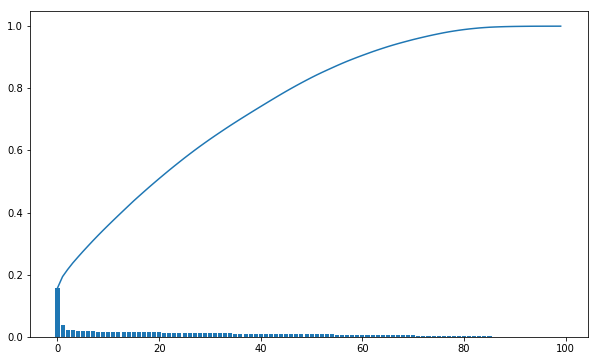

In [57]:
pca = PCA(k=100, inputCol="StdFeatures", outputCol="pcaFeatures")
model = pca.fit(data)

ind=np.arange(100)
val=np.array(model.explainedVariance)
cumvals=np.cumsum(val)
plt.figure(figsize=(10, 6))
ax = plt.subplot(111)
ax.bar(ind, val)
ax.plot(ind,cumvals)

use 0.01 as threshold, any components that are less than 0.01 variance will not be used

In [63]:
k=len(val[val>0.01])

In [64]:
print(k)

41


In [65]:
pca = PCA(k=41, inputCol="StdFeatures", outputCol="pcaFeatures")
model = pca.fit(data)
data = model.transform(data)

## Prepare training and testing data

In [67]:
data_churn = data.select(data.churn_Num.alias("label"), data.pcaFeatures.alias("features"))
data_down=data.select(data.downgrade_Num.alias("label"), data.pcaFeatures.alias("features"))

In this notebook, I will focus on churn user, since in this data subset, there is not difference between donwgrade user and churn user

In [70]:
data_churn.select('label').groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



In [155]:
train, validation = data_churn.randomSplit([0.7, 0.3], seed=110)

In [156]:
train.select('label').groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   38|
|  0.0|  115|
+-----+-----+



#### compenstate unbalanced data

In [157]:
labelcount_df=train.select('label').groupby('label').count().toPandas()

In [158]:
label1_count=int(labelcount_df[labelcount_df['label']==1]['count'].values)

In [159]:
label0_count=int(labelcount_df[labelcount_df['label']==0]['count'].values)

In [160]:
stratified_train = train.sampleBy('label', fractions={0: label1_count/label0_count, 1: 1.0}).cache()

In [161]:
stratified_train.select('label').groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   38|
|  0.0|   37|
+-----+-----+



In [162]:
stratified_train.show(1)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[0.13910696016942...|
+-----+--------------------+
only showing top 1 row



## Modeling

### Logistic regression

In [187]:
lr =  LogisticRegression(featuresCol = 'features', labelCol = 'label')
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.2]) \
    .addGrid(lr.regParam,[0.0, 0.1, 0.2, 0.3]) \
    .addGrid(lr.maxIter,[5, 10, 15]) \
    .build()

crossval_lr = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lr = crossval_lr.fit(stratified_train)
lr_avgMetrics=cvModel_lr.avgMetrics

In [188]:
results_lr = cvModel_lr.transform(validation)

In [189]:
BinaryClassificationEvaluator().evaluate(results_lr)

0.5677339901477831

In [190]:
cvModel_lr.bestModel.extractParamMap()

{Param(parent='LogisticRegression_7ee5f3816d1e', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_7ee5f3816d1e', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_7ee5f3816d1e', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_7ee5f3816d1e', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_7ee5f3816d1e', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_7ee5f3816d1e', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_7ee5f3816d1e', name='maxIter', doc='maximum number of iterations (>= 0)'): 

### random forest

In [191]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
paramGrid = ParamGridBuilder() \
    .addGrid(rf.impurity,['entropy']) \
    .addGrid(rf.maxDepth,[5, 10, 20]) \
    .addGrid(rf.numTrees,[5, 10, 20]) \
    .build()
crossval_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)


In [192]:
cvModel_rf= crossval_rf.fit(stratified_train)
rf_avgMetrics = cvModel_rf.avgMetrics

In [193]:
results_rf = cvModel_rf.transform(validation)

In [194]:
BinaryClassificationEvaluator().evaluate(results_rf)

0.5948275862068966

In [197]:
results_rf.show()

+-----+--------------------+-------------+-----------+----------+
|label|            features|rawPrediction|probability|prediction|
+-----+--------------------+-------------+-----------+----------+
|  0.0|[0.19573316090964...|    [7.0,3.0]|  [0.7,0.3]|       0.0|
|  0.0|[0.22557032056080...|    [4.0,6.0]|  [0.4,0.6]|       1.0|
|  0.0|[0.23364802835202...|    [5.0,5.0]|  [0.5,0.5]|       0.0|
|  0.0|[0.26539734766386...|    [3.0,7.0]|  [0.3,0.7]|       1.0|
|  0.0|[0.31598235080808...|    [6.0,4.0]|  [0.6,0.4]|       0.0|
|  0.0|[0.41871753030215...|    [5.0,5.0]|  [0.5,0.5]|       0.0|
|  0.0|[0.53548454929185...|    [2.0,8.0]|  [0.2,0.8]|       1.0|
|  0.0|[0.54729126350359...|    [4.0,6.0]|  [0.4,0.6]|       1.0|
|  0.0|[0.68203217082430...|    [1.0,9.0]|  [0.1,0.9]|       1.0|
|  0.0|[0.71403561033228...|    [5.0,5.0]|  [0.5,0.5]|       0.0|
|  0.0|[0.88972861434289...|    [5.0,5.0]|  [0.5,0.5]|       0.0|
|  0.0|[0.90484639519635...|    [6.0,4.0]|  [0.6,0.4]|       0.0|
|  0.0|[1.

In [195]:
cvModel_rf.bestModel.extractParamMap()

{Param(parent='RandomForestClassifier_d1e7ed7d5b57', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_d1e7ed7d5b57', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_d1e7ed7d5b57', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_d1e7ed7d5b57', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_d1e7ed7d5b57', 

In [170]:
gbts = GBTClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(gbts.maxIter,[3, 10, 20]) \
    .addGrid(gbts.maxDepth,[2, 4, 6, 8]) \
    .build()
crossval_gbts = CrossValidator(estimator=gbts,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_gbts = crossval_gbts.fit(stratified_train)
gbts_avgMetrics = cvModel_gbts.avgMetrics

In [171]:
results_gbts = cvModel_gbts.transform(validation)
BinaryClassificationEvaluator().evaluate(results_gbts)

0.5277093596059114

In [196]:
cvModel_gbts.bestModel.extractParamMap()

{Param(parent='GBTClassifier_a27448c13229', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='GBTClassifier_a27448c13229', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTClassifier_a27448c13229', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all',
 Param(parent='GBTClassifier_a27448c13229', name='featuresCol', doc='features column name'): 'features',
 Param(parent='GBTClassifier_a27448c13229', name='labelCol', doc='label column name'): 'la

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.